### Parallelization
#### Parallelization in LangGraph, nodes typically execute in a sequence defined by edges, but when the task don't depend on each other's outputs, you can run them in parallel. This is achieved by:
* Defining multiple nodes that can operate independently
* Connecting them to a common starting point (START or another node)
* Merging their outputs into a downstream node if needed.

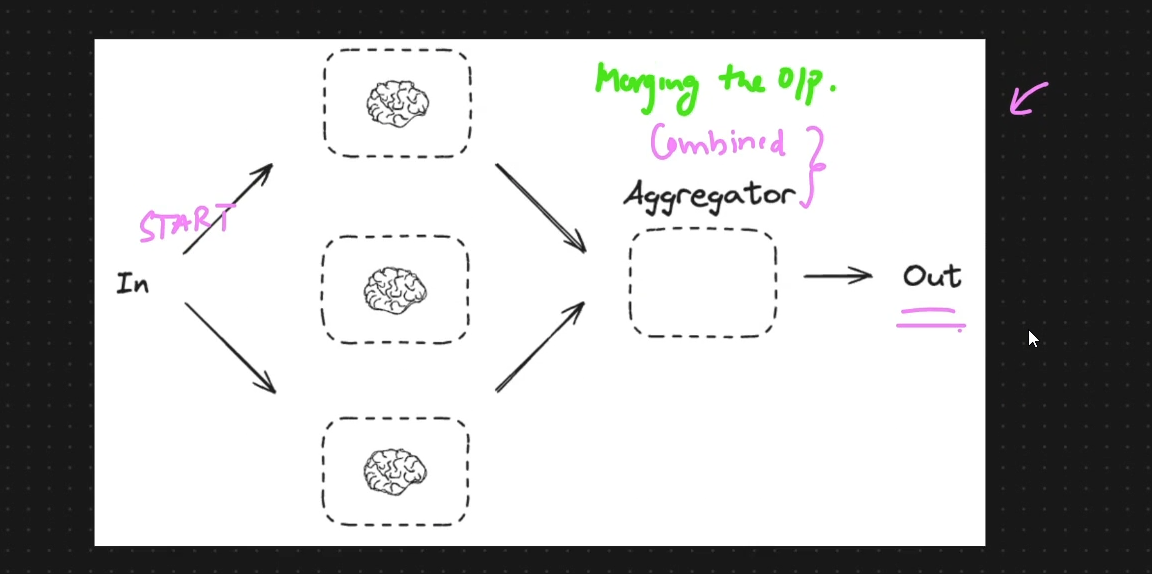
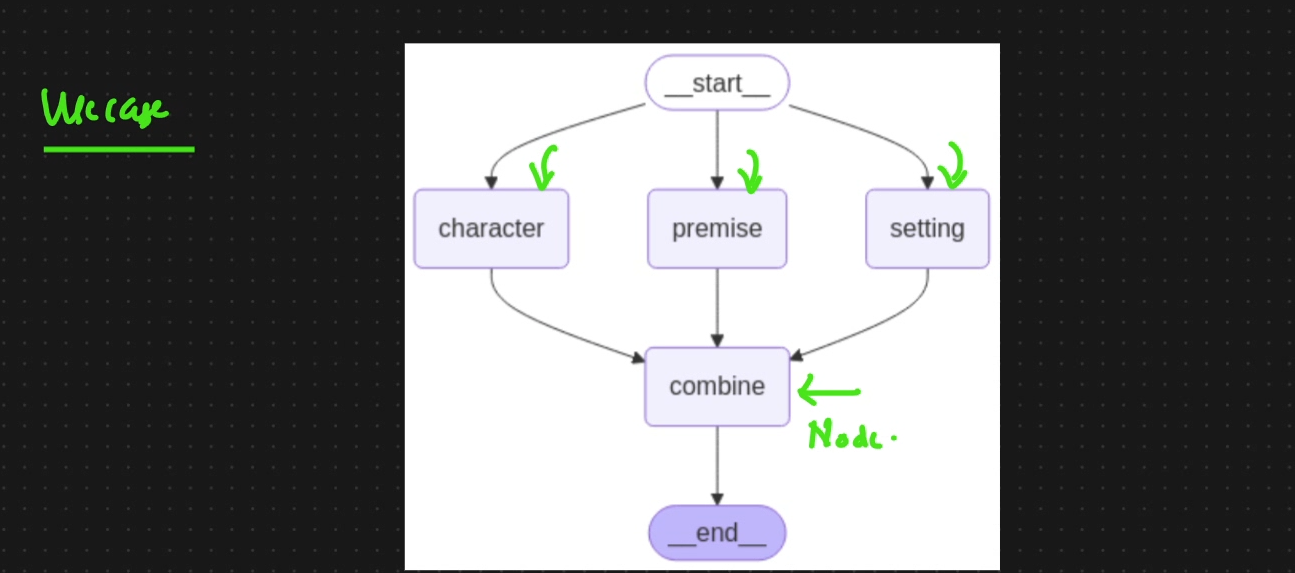

### Key Benefits:
* SPEED: Reduces total execution time by running tasks concurrently 
* SCALABILITY: Handles larger workflows efficiently
* MODULARITY: Keeps the graph structure clean and reusable

### Key Takeaways:
* When to parallelize: Use it for independent tasks (e.g.generating multiple outputs, checking separate inputs)
* Merging: Downstream nodes can aggregate parallel results
* LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding

In [1]:
# load LLM
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")
# if OPENAI use below LLM 
# llm=ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

c:\Users\venka\python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='<think>\nOkay, the user said "Hello". I should respond in a friendly and welcoming way. Maybe ask how I can assist them today. Keep it open-ended so they can specify their needs. Let me make sure the tone is positive and helpful.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 9, 'total_tokens': 74, 'completion_time': 0.141588402, 'completion_tokens_details': None, 'prompt_time': 0.000412288, 'prompt_tokens_details': None, 'queue_time': 0.078802269, 'total_time': 0.14200069}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_efa9879028', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7692-a568-7cb1-8dce-3b5d3c53d535-0', usage_metadata={'input_tokens': 9, 'output_tokens': 65, 'total_tokens': 74})

In [2]:
# Define the state
from typing_extensions import TypedDict 
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display 

# Graph State 
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro:str

In [13]:
# Nodes  (all these nodes are not dependent on each other. All these nodes are with same "topic")
def generate_characters(state:State):
    """Generate character descriptions"""
    msg=llm.invoke(f"Create two characters names and brief traits for a story about {state["topic"]}")
    return {"characters":msg.content}

def generate_settings(state:State):
    """Generate a story settings"""
    msg=llm.invoke(f"Describe a vivid setting for a story about {state["topic"]}")
    return {"settings":msg.content}

def generate_premise(state:State):
    """Generate a story premise"""
    msg=llm.invoke(f"Write a one-sentence plot premise for a story about {state["topic"]}")
    return {"premises":msg.content}

def combine_elements(state:State):
    """Combine characters, settings, and premise into an intro"""
    msg=llm.invoke(f"Write a short story intro using these elements:\n"
                   f"Characters: {state['characters']}\n"
                   f"Settings: {state['settings']}\n"
                   f"Premise: {state['premises']}"
                   )
    return {"story_intro":msg.content}

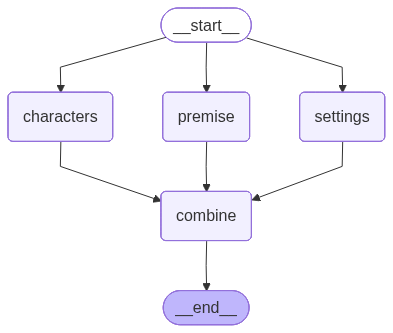

In [20]:
### Build the graph 

# Define the graph
graph=StateGraph(State)

# Define the nodes
graph.add_node("characters",generate_characters)
graph.add_node("settings",generate_settings)
graph.add_node("premise",generate_premise)
graph.add_node("combine",combine_elements)

# Define Edges
graph.add_edge(START,"characters")
graph.add_edge(START,"settings")
graph.add_edge(START,"premise")
graph.add_edge("characters","combine")
graph.add_edge("settings","combine")
graph.add_edge("premise","combine")
graph.add_edge("combine",END)

# Compile and Run 
compiled_graph=graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [22]:
### Invoke the graph 
state={"topic":"time travel"}
result=compiled_graph.invoke(state)
print(result["story_intro"])

<think>
Okay, I need to write a short story intro using the provided elements. Let me start by understanding what the user has given me. They have provided two characters, a setting, a premise, and some additional elements. My task is to craft an engaging opening that introduces the story, setting the scene and introducing the characters in a compelling way.

First, I need to recall the characters. Dr. Elara Voss is a brilliant but isolated quantum physicist haunted by her sister's death, driven by guilt to perfect her time-travel machine. Kael Mercer is a roguish historian with a deep respect for history's natural flow, who has encountered the consequences of time tampering. Their dynamic is built on conflicting motivations—Elara's desire to change the past versus Kael's need to preserve history.

The setting is the Chrono Nexus, a hub existing outside time with a mix of different eras, the Temporal Convergence Engine, Echo Chambers, and the Garden of Fractured Seasons. The premise in